#  Monte Carlo Simulations for Stock Price Predictions 

### A Monte Carlo simulation runs an enourmous amount of trials with different random numbers generated from an underlying distribution for the uncertain variables.
Let us try to implement this using one Technical Indicator as a reference for prediction.

In [1]:
# Install required packages (safe to re-run)
%pip install --quiet yfinance statsmodels pandas seaborn scikit-learn matplotlib plotly


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import datetime

import seaborn as sns
%matplotlib inline
from scipy.stats import norm
import yfinance as yf

# For ARIMA and SARIMA models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# For model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Configuration
TICKER = "AMZN"            # Change to any symbol supported by yfinance (e.g., "AAPL", "AMZN", "TSLA", "MSFT")
INTERVAL = "1wk"           # "1d", "1wk", "1mo" for yfinance
FORECAST_STEPS = 4         # Number of future periods to forecast (weeks when INTERVAL=="1wk")
START_DATE = "2020-12-11"  # Start date for historical data (YYYY-MM-DD format)
SEED = 42                  # Random seed for reproducibility



In [4]:
from datetime import date,timedelta

In [5]:
# Fetch stock data using yfinance (more reliable than yahoo_fin)
try:
    stock = yf.Ticker(TICKER)
    
    # yfinance history() method has different interval options
    # For weekly/monthly, we'll fetch daily and resample
    if INTERVAL == "1wk":
        # Fetch daily data and resample to weekly
        BSE = stock.history(start=START_DATE, end=date.today(), interval="1d")
        if not BSE.empty:
            # Resample to weekly (end of week)
            BSE = BSE.resample('W').agg({
                'Open': 'first',
                'High': 'max',
                'Low': 'min',
                'Close': 'last',
                'Volume': 'sum'
            })
            BSE.columns = [col.lower() for col in BSE.columns]
    elif INTERVAL == "1mo":
        # Fetch daily data and resample to monthly
        BSE = stock.history(start=START_DATE, end=date.today(), interval="1d")
        if not BSE.empty:
            BSE = BSE.resample('M').agg({
                'Open': 'first',
                'High': 'max',
                'Low': 'min',
                'Close': 'last',
                'Volume': 'sum'
            })
            BSE.columns = [col.lower() for col in BSE.columns]
    else:
        # For daily data, use directly
        BSE = stock.history(start=START_DATE, end=date.today(), interval=INTERVAL)
        if 'Close' in BSE.columns:
            BSE.columns = [col.lower() if col != 'Close' else col for col in BSE.columns]
    
    if BSE.empty:
        raise ValueError(f"No data retrieved for ticker {TICKER}")
    
    # Ensure we have the 'close' column (handle both cases)
    if 'Close' in BSE.columns:
        BSE['close'] = BSE['Close']
    elif 'close' not in BSE.columns:
        raise ValueError("No 'close' or 'Close' column found in data")
    
    # Ensure chronological order
    BSE = BSE.sort_index()
    
    # Remove any NaN rows
    BSE = BSE.dropna()
    
    print(f"✓ Successfully loaded data for {TICKER}")
    print(f"  Data shape: {BSE.shape}")
    print(f"  Date range: {BSE.index[0].date()} to {BSE.index[-1].date()}")
    print(f"  Interval: {INTERVAL}")
    print(f"\nFirst few rows:")
    display_cols = ['close']
    if 'open' in BSE.columns:
        display_cols = ['open', 'high', 'low', 'close']
    if 'volume' in BSE.columns:
        display_cols.append('volume')
    print(BSE[display_cols].head())
    
except Exception as e:
    print(f"Error fetching data: {e}")
    print(f"\nTrying alternative download method...")
    # Fallback: try using yf.download
    try:
        BSE = yf.download(TICKER, start=START_DATE, end=date.today(), progress=False, auto_adjust=True)
        
        if BSE.empty:
            raise ValueError(f"No data retrieved for ticker {TICKER}")
        
        # Resample if needed
        if INTERVAL == "1wk":
            BSE = BSE.resample('W').agg({
                'Open': 'first',
                'High': 'max',
                'Low': 'min',
                'Close': 'last',
                'Volume': 'sum'
            })
        elif INTERVAL == "1mo":
            BSE = BSE.resample('M').agg({
                'Open': 'first',
                'High': 'max',
                'Low': 'min',
                'Close': 'last',
                'Volume': 'sum'
            })
        
        BSE.columns = [col[0] if isinstance(col, tuple) else col for col in BSE.columns]
        BSE.columns = [col.lower() for col in BSE.columns]
        
        if 'close' not in BSE.columns and 'Close' in BSE.columns:
            BSE['close'] = BSE['Close']
        
        BSE = BSE.sort_index().dropna()
        print(f"✓ Successfully loaded data using alternative method")
        print(f"  Data shape: {BSE.shape}")
        print(f"  Date range: {BSE.index[0].date()} to {BSE.index[-1].date()}")
    except Exception as e2:
        print(f"✗ Alternative method also failed: {e2}")
        print(f"\nPlease check:")
        print(f"  1. Ticker symbol '{TICKER}' is correct")
        print(f"  2. You have an internet connection")
        print(f"  3. Try a different ticker (e.g., 'AAPL', 'MSFT', 'GOOGL')")
        raise

✓ Successfully loaded data for AMZN
  Data shape: (257, 5)
  Date range: 2020-12-13 to 2025-11-09
  Interval: 1wk

First few rows:
                                 open        high         low       close  \
Date                                                                        
2020-12-13 00:00:00-05:00  154.832993  155.933502  153.641006  155.820999   
2020-12-20 00:00:00-05:00  157.149994  163.175507  156.300003  160.082504   
2020-12-27 00:00:00-05:00  160.000504  161.348495  158.300003  158.634506   
2021-01-03 00:00:00-05:00  159.699997  167.532501  158.634506  162.846497   
2021-01-10 00:00:00-05:00  163.500000  163.600006  156.557999  159.134995   

                              volume  
Date                                  
2020-12-13 00:00:00-05:00   61294000  
2020-12-20 00:00:00-05:00  427458000  
2020-12-27 00:00:00-05:00  195038000  
2021-01-03 00:00:00-05:00  334524000  
2021-01-10 00:00:00-05:00  370278000  


In [6]:
BSE

,open,high,low,close,volume
Date,,,,,
2020-12-13 00:00:00-05:00,154.832993,155.933502,153.641006,155.820999,61294000
2020-12-20 00:00:00-05:00,157.149994,163.175507,156.300003,160.082504,427458000
2020-12-27 00:00:00-05:00,160.000504,161.348495,158.300003,158.634506,195038000
2021-01-03 00:00:00-05:00,159.699997,167.532501,158.634506,162.846497,334524000
2021-01-10 00:00:00-05:00,163.500000,163.600006,156.557999,159.134995,370278000
...,...,...,...,...,...
2025-10-12 00:00:00-04:00,221.000000,228.250000,216.000000,216.369995,240351200
2025-10-19 00:00:00-04:00,217.699997,220.679993,211.029999,213.039993,217786300
2025-10-26 00:00:00-04:00,213.880005,225.399994,213.589996,224.210007,203911000


In [7]:
BSE.index

DatetimeIndex(['2020-12-13 00:00:00-05:00', '2020-12-20 00:00:00-05:00',
               '2020-12-27 00:00:00-05:00', '2021-01-03 00:00:00-05:00',
               '2021-01-10 00:00:00-05:00', '2021-01-17 00:00:00-05:00',
               '2021-01-24 00:00:00-05:00', '2021-01-31 00:00:00-05:00',
               '2021-02-07 00:00:00-05:00', '2021-02-14 00:00:00-05:00',
               ...
               '2025-09-07 00:00:00-04:00', '2025-09-14 00:00:00-04:00',
               '2025-09-21 00:00:00-04:00', '2025-09-28 00:00:00-04:00',
               '2025-10-05 00:00:00-04:00', '2025-10-12 00:00:00-04:00',
               '2025-10-19 00:00:00-04:00', '2025-10-26 00:00:00-04:00',
               '2025-11-02 00:00:00-04:00', '2025-11-09 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=257, freq='W-SUN')

In [8]:
# Split data: training set (all except last FORECAST_STEPS periods) and test set (last FORECAST_STEPS periods)
train = BSE['close'][:-FORECAST_STEPS].copy()
test = BSE['close'][-FORECAST_STEPS:].copy()

print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print(f"Training period: {train.index[0].date()} to {train.index[-1].date()}")
print(f"Test period: {test.index[0].date()} to {test.index[-1].date()}")


Training data shape: (253,)
Test data shape: (4,)
Training period: 2020-12-13 to 2025-10-12
Test period: 2025-10-19 to 2025-11-09


### Now that we have the data we need to find:

#### Expected_return= "Mean of close till now" (we can use different methods here)
#### Volatility=Standard deviation
#### dt=1/252

Text(13.819444444444445, 0.5, 'Frequency')

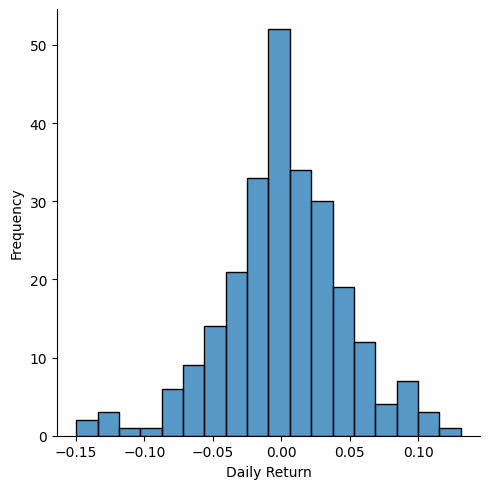

In [9]:
log_returns = np.log(1 + train.pct_change()) # Calculating log of Percent change per day (log is taken to normalize)
sns.displot(log_returns.iloc[1:])
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

In [10]:
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5*var)

In [11]:
# Annualized volatility (weekly data, so multiply by sqrt(52) for weekly, not 252)
volatility = np.std(log_returns) * np.sqrt(52)  # 52 weeks in a year
print(f"Annualized Volatility: {volatility:.4f}")

Annualized Volatility: 0.3212


In [12]:
stdev = log_returns.std()
trials = 1000

# Geometric Brownian Motion formula (for reference):
# S = S0 * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
# Where:
# S0 = initial stock price
# r = drift (expected return)
# sigma = volatility
# dt = time step
# Z = random normal variable

In [13]:
from dateutil import relativedelta
delta = relativedelta.relativedelta(train.index[-1], train.index[0])
decimal_years = delta.years + (delta.months + delta.days/31) / 12
print(f"Decimal years: {decimal_years:.4f}")

Decimal years: 4.8280


In [ ]:
# Monte Carlo Simulation Parameters
num_steps = 4  # Number of weeks to predict
num_paths = 1000  # Number of simulation paths

# dt should be one week as a fraction of a year (1/52 for weekly data)
# For weekly data: dt = 1/52 ≈ 0.0192 years per step
dt = 1 / 52  # One week in years

# Get initial stock price (ensure it's a scalar value)
initial_price = float(train.iloc[-1])  # Convert to float to ensure scalar

# Initialize stock prices array
stock_prices = np.zeros((num_paths, num_steps + 1))
stock_prices[:, 0] = initial_price  # Set initial price for all paths

# Simulate stock prices using Geometric Brownian Motion
np.random.seed(42)  # For reproducibility
for path in range(num_paths):
    for step in range(1, num_steps + 1):
        # Generate a random return for each step
        # Using weekly drift and volatility (already annualized)
        random_return = np.random.normal(
            loc=(drift - 0.5 * volatility ** 2) * dt,
            scale=volatility * np.sqrt(dt)
        )
        stock_prices[path, step] = stock_prices[path, step - 1] * np.exp(random_return)

# Calculate statistics
mc_predictions = stock_prices[:, 1:]
mc_mean = np.mean(mc_predictions, axis=0)
mc_std = np.std(mc_predictions, axis=0)
mc_median = np.median(mc_predictions, axis=0)

print("Monte Carlo Simulation Results:")
print(f"Initial price: ${initial_price:.2f}")
print(f"Mean predictions: {mc_mean}")
print(f"Std predictions: {mc_std}")
print(f"dt (time step): {dt:.4f} years (1 week)")

Monte Carlo Simulation Results:
Mean predictions: [217.76085715 221.08718085 218.91457268 221.45260805]
Std predictions: [ 75.57745393 123.13164662 152.56261842 174.33991393]


In [15]:
stock_prices

array([[216.36999512, 242.34981017, 216.95414917, 256.30247086,
        412.37978083],
       [216.36999512, 187.25171866, 162.05301145, 265.95771502,
        327.75581154],
       [216.36999512, 172.32932609, 196.16947849, 156.57480331,
        124.86995426],
       ...,
       [216.36999512, 400.96974694, 286.75182941, 148.50084944,
        118.1998283 ],
       [216.36999512, 101.28359333, 124.1004261 ,  56.28380659,
         53.4393876 ],
       [216.36999512,  97.69140173,  82.01289418, 137.68035161,
        146.98172291]])

In [16]:
Sp=pd.DataFrame(stock_prices[:,1:],columns=[f"Week {i+1}" for i in range(num_steps)])
Sp.describe()

,Week 1,Week 2,Week 3,Week 4
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,217.760857,221.087181,218.914573,221.452608
std,75.615271,123.193259,152.638957,174.427149
min,70.069021,41.054008,29.342713,20.398541
25%,163.821353,138.918765,122.269752,104.270832
50%,207.455562,190.389670,182.093341,174.982140
75%,257.167998,270.726028,271.029585,275.709985
max,638.804785,1355.841236,1577.364977,1440.901521


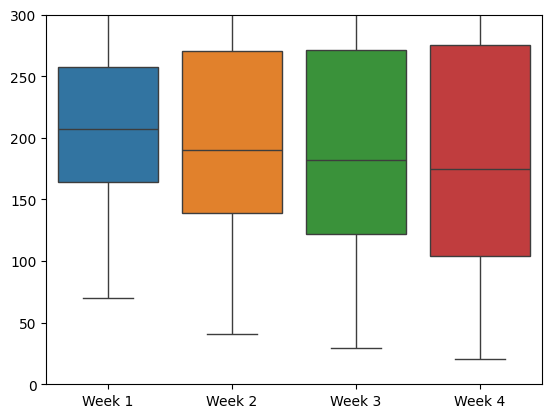

In [17]:
sns.boxplot(Sp)
plt.ylim(0, 300)  # Specify your desired limits here

# Show the plot
plt.show()

In [18]:
# Actual test values
actual_prices = test.values
print("Actual prices for test period:")
print(pd.DataFrame(actual_prices, index=test.index, columns=['Actual Price']))

Actual prices for test period:
                           Actual Price
Date                                   
2025-10-19 00:00:00-04:00    213.039993
2025-10-26 00:00:00-04:00    224.210007
2025-11-02 00:00:00-04:00    244.220001
2025-11-09 00:00:00-05:00    244.410004


## 2. ARIMA Model Implementation

ARIMA (AutoRegressive Integrated Moving Average) is a time series forecasting model that uses:
- **AR (p)**: Autoregressive terms - uses past values
- **I (d)**: Differencing - makes the series stationary
- **MA (q)**: Moving average terms - uses past forecast errors


In [19]:
# Check for stationarity using Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    """Check if time series is stationary"""
    result = adfuller(timeseries.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print("✓ Series is stationary (reject null hypothesis)")
        return True
    else:
        print("✗ Series is not stationary (fail to reject null hypothesis)")
        return False

print("Checking stationarity of original series:")
is_stationary = check_stationarity(train)


Checking stationarity of original series:
ADF Statistic: -1.0076811153652263
p-value: 0.7504524914003864
Critical Values:
	1%: -3.4565688966099373
	5%: -2.8730786194395455
	10%: -2.5729189953388762
✗ Series is not stationary (fail to reject null hypothesis)


In [20]:
# Make the series stationary if needed (differencing)
train_diff = train.diff().dropna()
print("\nChecking stationarity of differenced series:")
is_stationary_diff = check_stationarity(train_diff)



Checking stationarity of differenced series:
ADF Statistic: -16.412663725278577
p-value: 2.574762712828232e-29
Critical Values:
	1%: -3.4566744514553016
	5%: -2.8731248767783426
	10%: -2.5729436702592023
✓ Series is stationary (reject null hypothesis)


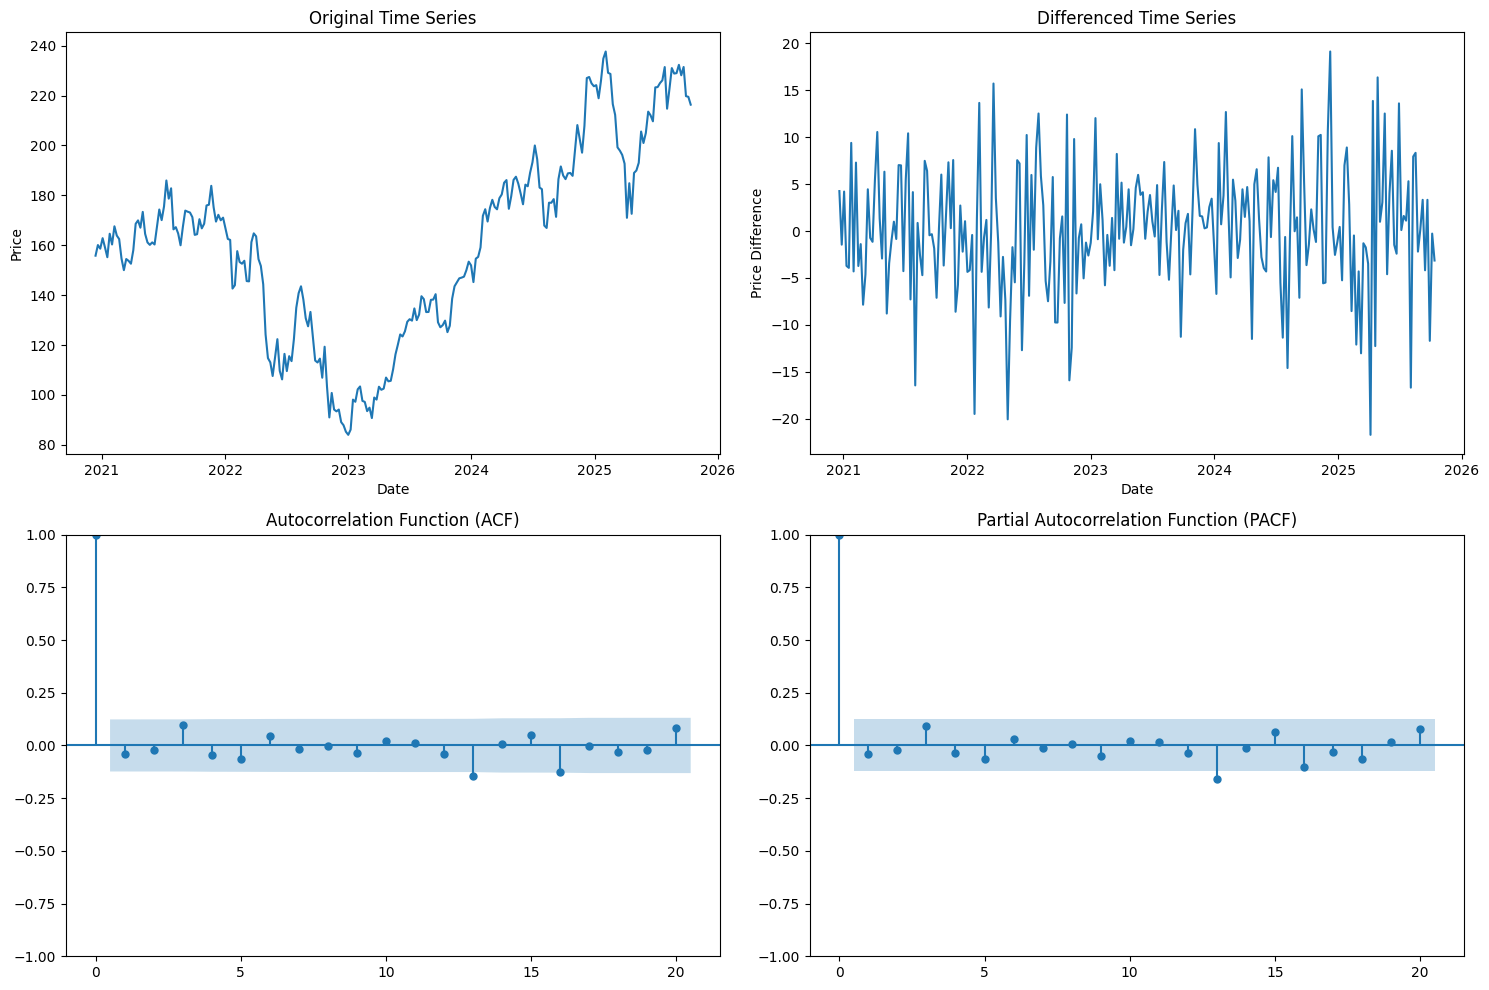

In [21]:
# Plot ACF and PACF to help determine ARIMA parameters
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original series
axes[0, 0].plot(train.index, train.values)
axes[0, 0].set_title('Original Time Series')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price')

# Differenced series
axes[0, 1].plot(train_diff.index, train_diff.values)
axes[0, 1].set_title('Differenced Time Series')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Price Difference')

# ACF plot
plot_acf(train_diff.dropna(), lags=20, ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(train_diff.dropna(), lags=20, ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [22]:
# Auto-select ARIMA parameters using AIC (Akaike Information Criterion)
def find_best_arima(train_data, max_p=5, max_d=2, max_q=5):
    """Find best ARIMA parameters using grid search"""
    best_aic = np.inf
    best_params = None
    best_model = None
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(train_data, order=(p, d, q))
                    fitted_model = model.fit()
                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_params = (p, d, q)
                        best_model = fitted_model
                except:
                    continue
    
    return best_params, best_model, best_aic

print("Finding best ARIMA parameters...")
best_arima_params, best_arima_model, best_aic = find_best_arima(train)
print(f"Best ARIMA parameters: {best_arima_params}")
print(f"Best AIC: {best_aic:.2f}")
print("\nModel Summary:")
print(best_arima_model.summary())


Finding best ARIMA parameters...
Best ARIMA parameters: (0, 1, 0)
Best AIC: 1676.10

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -837.052
Date:                Sat, 08 Nov 2025   AIC                           1676.104
Time:                        20:46:46   BIC                           1679.633
Sample:                    12-13-2020   HQIC                          1677.524
                         - 10-12-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        44.9428      3.506     12.818      0.000      38.071      51.815
Ljung-Box (L1) (Q):            

In [23]:
# Fit ARIMA model with best parameters
arima_model = ARIMA(train, order=best_arima_params)
arima_fitted = arima_model.fit()

# Forecast next 4 weeks
arima_forecast = arima_fitted.forecast(steps=4)
arima_forecast_ci = arima_fitted.get_forecast(steps=4).conf_int()

print("ARIMA Forecast:")
print(arima_forecast)


ARIMA Forecast:
2025-10-19 00:00:00-04:00    216.369995
2025-10-26 00:00:00-04:00    216.369995
2025-11-02 00:00:00-04:00    216.369995
2025-11-09 00:00:00-05:00    216.369995
Freq: W-SUN, Name: predicted_mean, dtype: float64


## 3. SARIMA Model Implementation

SARIMA (Seasonal AutoRegressive Integrated Moving Average) extends ARIMA by adding seasonal components:
- **Seasonal AR (P)**: Seasonal autoregressive terms
- **Seasonal I (D)**: Seasonal differencing
- **Seasonal MA (Q)**: Seasonal moving average terms
- **s**: Seasonal period (e.g., 4 for quarterly, 12 for monthly, 52 for weekly)


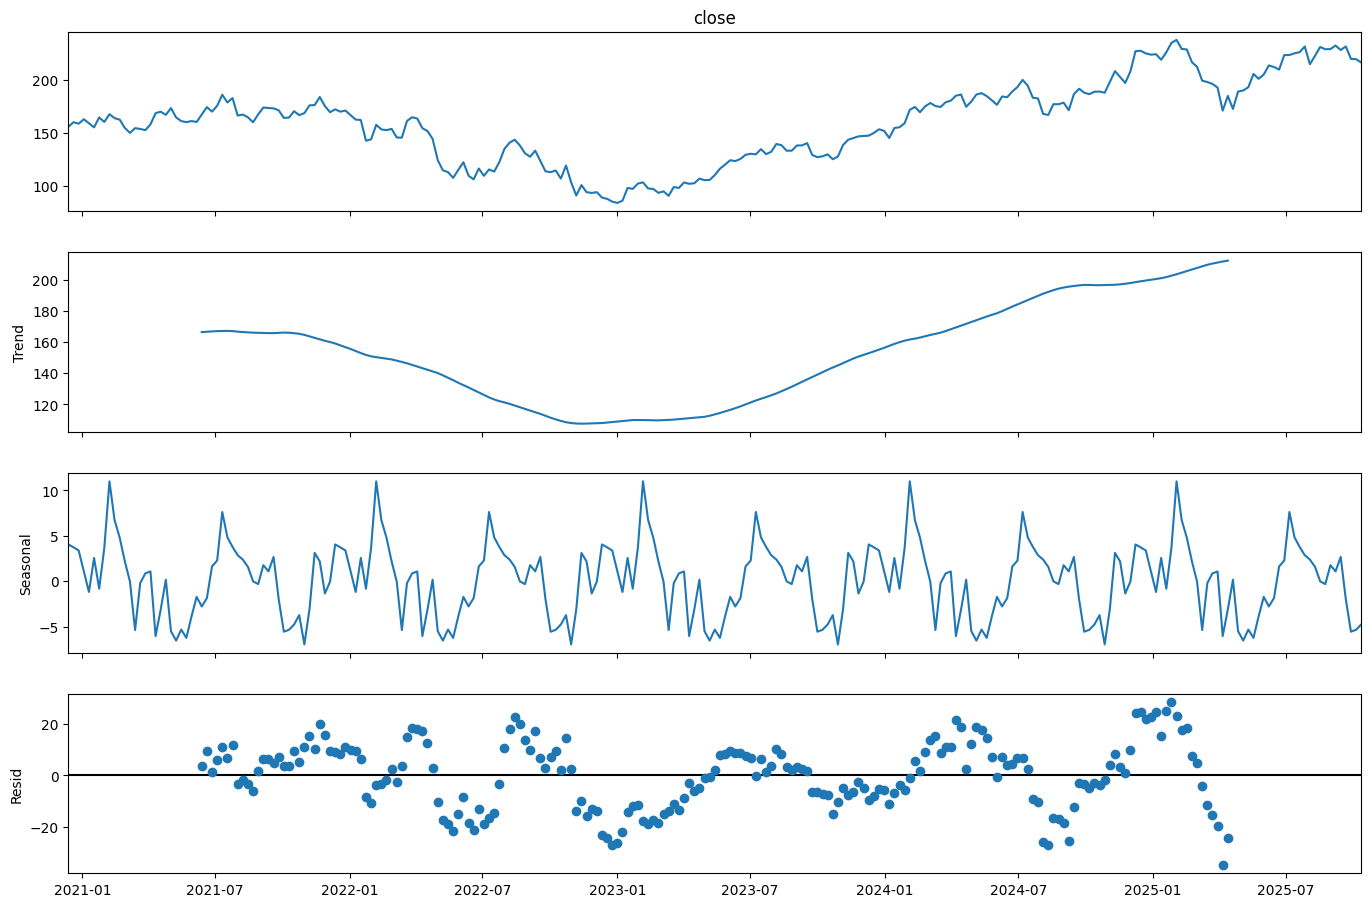

In [24]:
# Decompose time series to check for seasonality
decomposition = seasonal_decompose(train, model='additive', period=min(52, len(train)//2))
fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.show()


In [25]:
# Optimized SARIMA parameter selection (MUCH FASTER!)
# Strategy: Use best ARIMA params as starting point, then search nearby seasonal params

def find_best_sarima_fast(train_data, arima_params, s=52):
    """
    Fast SARIMA parameter search using ARIMA params as starting point
    Only searches seasonal components (P, D, Q) around common values
    """
    p, d, q = arima_params
    best_aic = np.inf
    best_params = None
    best_model = None
    
    # Reduced search space for seasonal components only
    # Common seasonal orders: (0,0,0), (0,1,0), (1,0,0), (0,0,1), (1,1,0), (0,1,1)
    seasonal_orders = [
        (0, 0, 0),  # No seasonality
        (0, 1, 0),  # Seasonal differencing only
        (1, 0, 0),  # Seasonal AR only
        (0, 0, 1),  # Seasonal MA only
        (1, 1, 0),  # Seasonal AR + differencing
        (0, 1, 1),  # Seasonal MA + differencing
        (1, 0, 1),  # Seasonal AR + MA
        (1, 1, 1),  # All seasonal components
    ]
    
    total_models = len(seasonal_orders)
    print(f"Testing {total_models} SARIMA models (using ARIMA({p},{d},{q}) as base)...")
    
    for idx, (P, D, Q) in enumerate(seasonal_orders, 1):
        try:
            model = SARIMAX(train_data, 
                           order=(p, d, q),
                           seasonal_order=(P, D, Q, s),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
            # Use faster optimization method
            fitted_model = model.fit(method='lbfgs', disp=False, maxiter=50)
            
            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_params = ((p, d, q), (P, D, Q, s))
                best_model = fitted_model
                print(f"  [{idx}/{total_models}] SARIMA{p,d,q}x{P,D,Q}_{s}: AIC={best_aic:.2f} ✓ NEW BEST")
            else:
                print(f"  [{idx}/{total_models}] SARIMA{p,d,q}x{P,D,Q}_{s}: AIC={fitted_model.aic:.2f}")
        except Exception as e:
            print(f"  [{idx}/{total_models}] SARIMA{p,d,q}x{P,D,Q}_{s}: Failed - {str(e)[:50]}")
            continue
    
    return best_params, best_model, best_aic

print("Finding best SARIMA parameters (optimized search)...")
print("=" * 60)

# Use the best ARIMA parameters we already found
if 'best_arima_params' not in locals():
    print("⚠ Warning: best_arima_params not found. Running quick ARIMA search first...")
    # Quick ARIMA search
    best_aic_arima = np.inf
    best_arima_params = None
    for p in [0, 1, 2]:
        for d in [0, 1]:
            for q in [0, 1, 2]:
                try:
                    model = ARIMA(train, order=(p, d, q))
                    fitted = model.fit()
                    if fitted.aic < best_aic_arima:
                        best_aic_arima = fitted.aic
                        best_arima_params = (p, d, q)
                except:
                    continue
    print(f"Quick ARIMA search result: {best_arima_params} (AIC: {best_aic_arima:.2f})")

best_sarima_params, best_sarima_model, best_sarima_aic = find_best_sarima_fast(train, best_arima_params, s=52)

print("\n" + "=" * 60)
print(f"✓ Best SARIMA parameters: {best_sarima_params}")
print(f"✓ Best AIC: {best_sarima_aic:.2f}")
print("\nModel Summary:")
print(best_sarima_model.summary())


Finding best SARIMA parameters (optimized search)...
Testing 8 SARIMA models (using ARIMA(0,1,0) as base)...
  [1/8] SARIMA(0, 1, 0)x(0, 0, 0)_52: AIC=1670.06 ✓ NEW BEST
  [2/8] SARIMA(0, 1, 0)x(0, 1, 0)_52: AIC=1460.95 ✓ NEW BEST
  [3/8] SARIMA(0, 1, 0)x(1, 0, 0)_52: AIC=1346.51 ✓ NEW BEST
  [4/8] SARIMA(0, 1, 0)x(0, 0, 1)_52: AIC=1339.11 ✓ NEW BEST
  [5/8] SARIMA(0, 1, 0)x(1, 1, 0)_52: AIC=1027.45 ✓ NEW BEST
  [6/8] SARIMA(0, 1, 0)x(0, 1, 1)_52: AIC=5157.89
  [7/8] SARIMA(0, 1, 0)x(1, 0, 1)_52: AIC=1333.19
  [8/8] SARIMA(0, 1, 0)x(1, 1, 1)_52: AIC=4957.47

✓ Best SARIMA parameters: ((0, 1, 0), (1, 1, 0, 52))
✓ Best AIC: 1027.45

Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                              close   No. Observations:                  253
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 52)   Log Likelihood                -511.725
Date:                            Sat, 08 Nov 2025   AIC                  

In [26]:
# Forecast using SARIMA
sarima_forecast = best_sarima_model.forecast(steps=4)
sarima_forecast_ci = best_sarima_model.get_forecast(steps=4).conf_int()

print("SARIMA Forecast:")
print(sarima_forecast)


SARIMA Forecast:
2025-10-19 00:00:00-04:00    214.536588
2025-10-26 00:00:00-04:00    214.936651
2025-11-02 00:00:00-04:00    225.354518
2025-11-09 00:00:00-05:00    233.391982
Freq: W-SUN, Name: predicted_mean, dtype: float64


## 4. Model Evaluation and Comparison


In [27]:
# Calculate evaluation metrics for all models
def calculate_metrics(actual, predicted, model_name):
    """Calculate MAE, RMSE, and MAPE"""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape
    }

# Monte Carlo metrics (using mean predictions)
mc_metrics = calculate_metrics(actual_prices, mc_mean, 'Monte Carlo')

# ARIMA metrics
arima_metrics = calculate_metrics(actual_prices, arima_forecast.values, 'ARIMA')

# SARIMA metrics
sarima_metrics = calculate_metrics(actual_prices, sarima_forecast.values, 'SARIMA')

# Create comparison dataframe
comparison_df = pd.DataFrame([mc_metrics, arima_metrics, sarima_metrics])
print("\nModel Comparison - Evaluation Metrics:")
print(comparison_df.to_string(index=False))



Model Comparison - Evaluation Metrics:
      Model       MAE      RMSE  MAPE (%)
Monte Carlo 14.026628 17.316505  5.840871
      ARIMA 16.765007 20.213978  6.984000
     SARIMA 10.163364 11.890524  4.267827


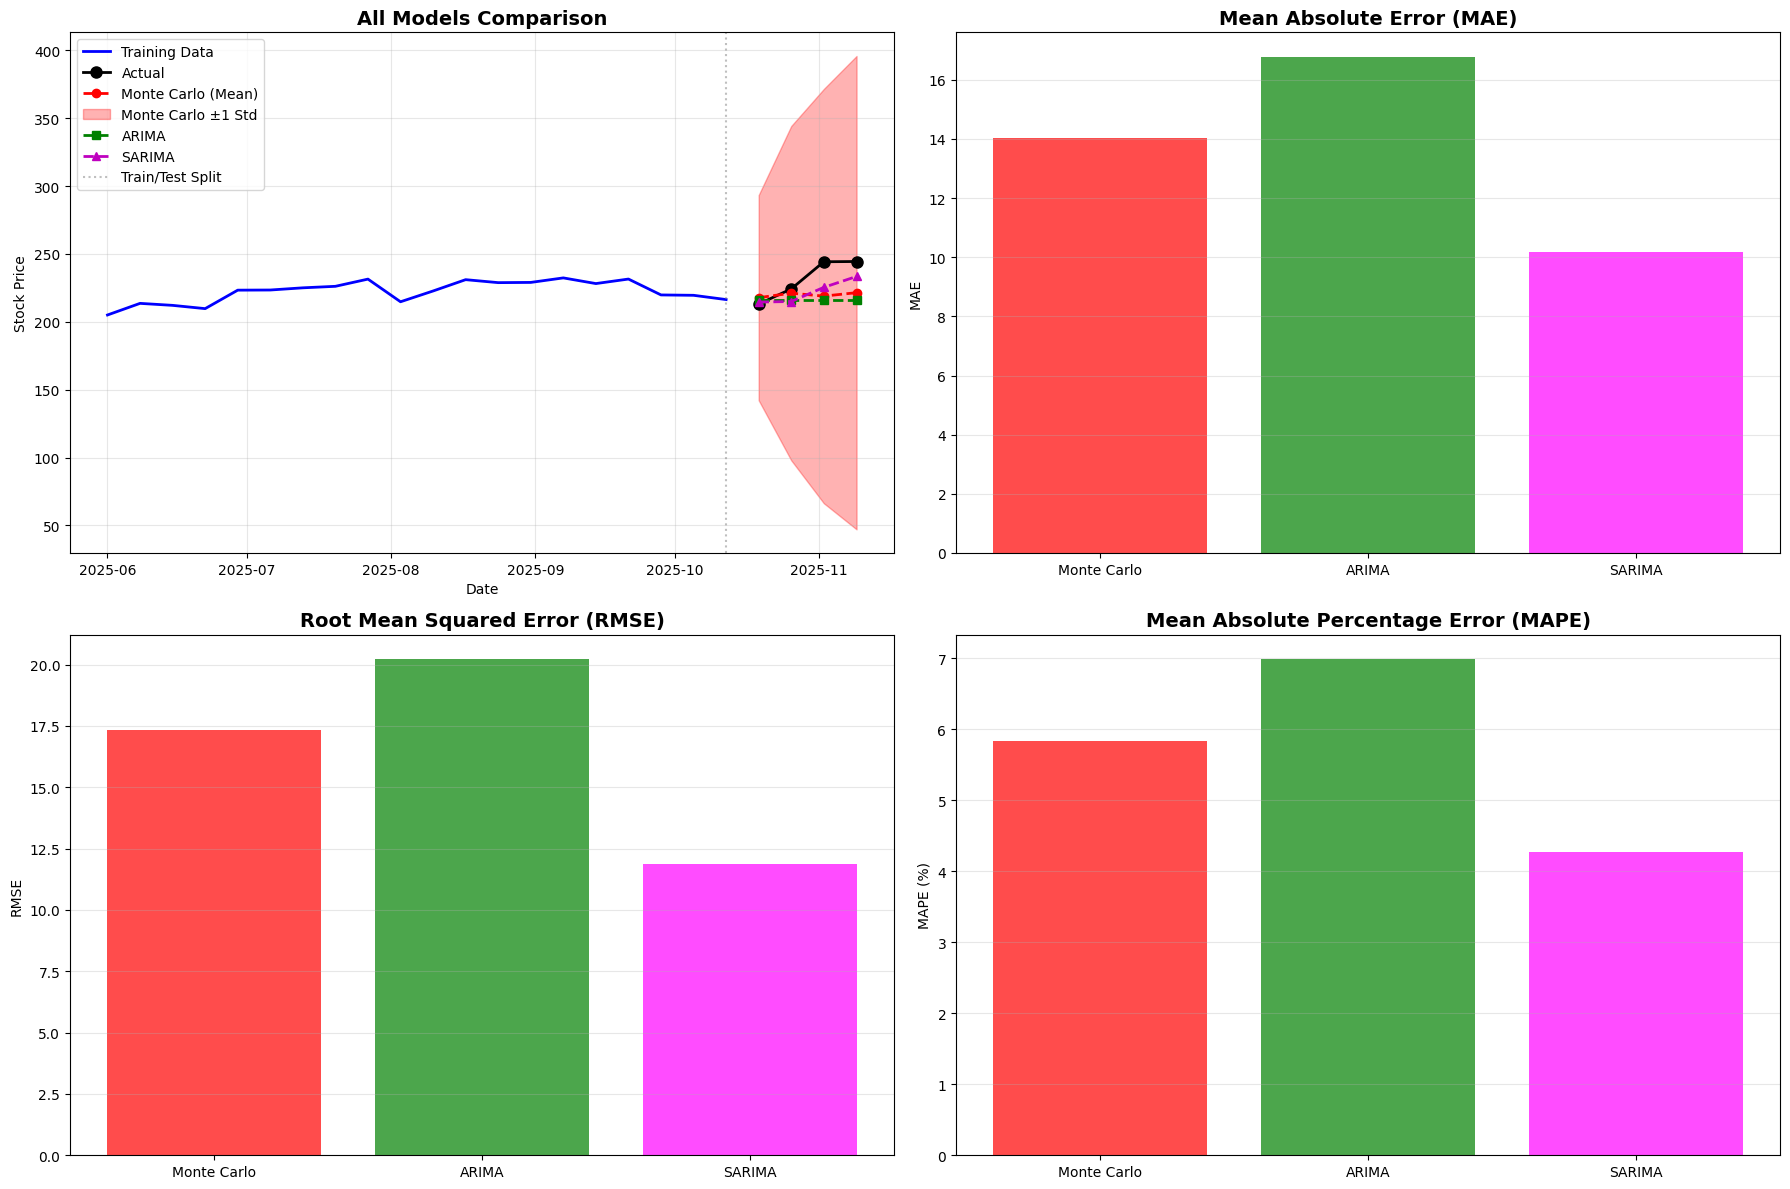

In [28]:
# Visualize all predictions together
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Get date range for predictions
prediction_dates = test.index
last_train_date = train.index[-1]

# Plot 1: All models comparison
axes[0, 0].plot(train.index[-20:], train.values[-20:], 'b-', label='Training Data', linewidth=2)
axes[0, 0].plot(prediction_dates, actual_prices, 'ko-', label='Actual', linewidth=2, markersize=8)
axes[0, 0].plot(prediction_dates, mc_mean, 'r--', label='Monte Carlo (Mean)', linewidth=2, marker='o')
axes[0, 0].fill_between(prediction_dates, mc_mean - mc_std, mc_mean + mc_std, 
                        alpha=0.3, color='red', label='Monte Carlo ±1 Std')
axes[0, 0].plot(prediction_dates, arima_forecast.values, 'g--', label='ARIMA', linewidth=2, marker='s')
axes[0, 0].plot(prediction_dates, sarima_forecast.values, 'm--', label='SARIMA', linewidth=2, marker='^')
axes[0, 0].axvline(x=last_train_date, color='gray', linestyle=':', alpha=0.5, label='Train/Test Split')
axes[0, 0].set_title('All Models Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Stock Price')
axes[0, 0].legend(loc='best')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Prediction errors
axes[0, 1].bar(['Monte Carlo', 'ARIMA', 'SARIMA'], 
               [mc_metrics['MAE'], arima_metrics['MAE'], sarima_metrics['MAE']],
               color=['red', 'green', 'magenta'], alpha=0.7)
axes[0, 1].set_title('Mean Absolute Error (MAE)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: RMSE comparison
axes[1, 0].bar(['Monte Carlo', 'ARIMA', 'SARIMA'], 
               [mc_metrics['RMSE'], arima_metrics['RMSE'], sarima_metrics['RMSE']],
               color=['red', 'green', 'magenta'], alpha=0.7)
axes[1, 0].set_title('Root Mean Squared Error (RMSE)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: MAPE comparison
axes[1, 1].bar(['Monte Carlo', 'ARIMA', 'SARIMA'], 
               [mc_metrics['MAPE (%)'], arima_metrics['MAPE (%)'], sarima_metrics['MAPE (%)']],
               color=['red', 'green', 'magenta'], alpha=0.7)
axes[1, 1].set_title('Mean Absolute Percentage Error (MAPE)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('MAPE (%)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [29]:
# Detailed prediction comparison table
prediction_comparison = pd.DataFrame({
    'Date': prediction_dates,
    'Actual': actual_prices,
    'Monte Carlo': mc_mean,
    'Monte Carlo Std': mc_std,
    'ARIMA': arima_forecast.values,
    'SARIMA': sarima_forecast.values
})

prediction_comparison['MC Error'] = abs(prediction_comparison['Actual'] - prediction_comparison['Monte Carlo'])
prediction_comparison['ARIMA Error'] = abs(prediction_comparison['Actual'] - prediction_comparison['ARIMA'])
prediction_comparison['SARIMA Error'] = abs(prediction_comparison['Actual'] - prediction_comparison['SARIMA'])

print("\nDetailed Prediction Comparison:")
print(prediction_comparison.round(2))



Detailed Prediction Comparison:
                       Date  Actual  Monte Carlo  Monte Carlo Std   ARIMA  \
0 2025-10-19 00:00:00-04:00  213.04       217.76            75.58  216.37   
1 2025-10-26 00:00:00-04:00  224.21       221.09           123.13  216.37   
2 2025-11-02 00:00:00-04:00  244.22       218.91           152.56  216.37   
3 2025-11-09 00:00:00-05:00  244.41       221.45           174.34  216.37   

   SARIMA  MC Error  ARIMA Error  SARIMA Error  
0  214.54      4.72         3.33          1.50  
1  214.94      3.12         7.84          9.27  
2  225.35     25.31        27.85         18.87  
3  233.39     22.96        28.04         11.02  


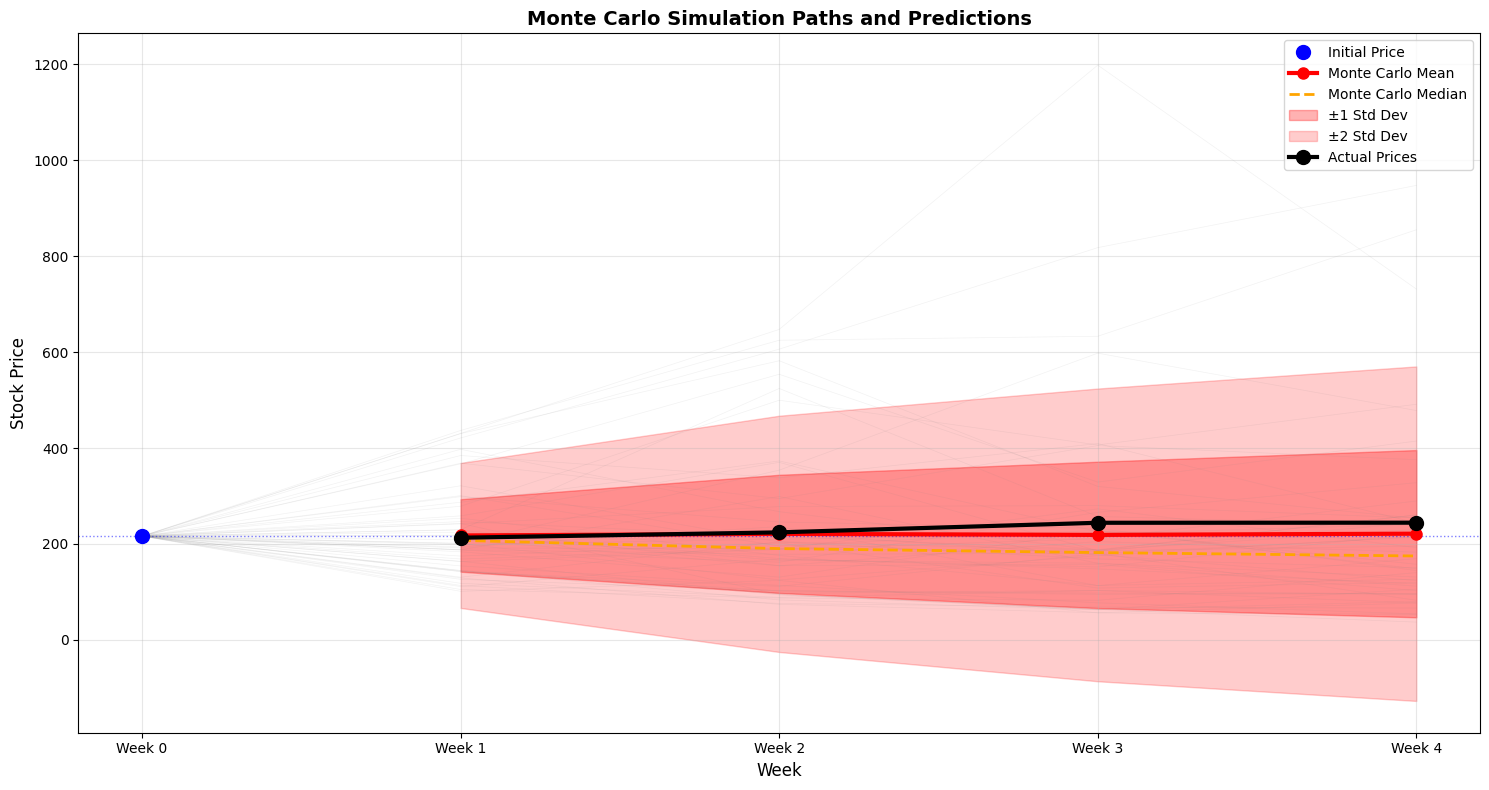

In [34]:
# Plot Monte Carlo simulation paths
fig, ax = plt.subplots(figsize=(15, 8))

# Get initial price (from stock_prices if initial_price not defined)
if 'initial_price' in locals() or 'initial_price' in globals():
    init_price = initial_price
else:
    init_price = float(stock_prices[0, 0])  # Get from first path, first step

# Plot sample of Monte Carlo paths
sample_paths = np.random.choice(num_paths, size=min(50, num_paths), replace=False)
for path in sample_paths:
    ax.plot(range(num_steps + 1), stock_prices[path], alpha=0.1, color='gray', linewidth=0.5)

# Plot initial price as a single point/horizontal line
ax.plot([0], [init_price], 'bo', linewidth=2, markersize=10, label='Initial Price')
ax.axhline(y=init_price, color='blue', linestyle=':', alpha=0.5, linewidth=1)

# Plot mean, median, and confidence intervals
ax.plot(range(1, num_steps + 1), mc_mean, 'r-', linewidth=3, label='Monte Carlo Mean', marker='o', markersize=8)
ax.plot(range(1, num_steps + 1), mc_median, 'orange', linewidth=2, linestyle='--', label='Monte Carlo Median')
ax.fill_between(range(1, num_steps + 1), mc_mean - mc_std, mc_mean + mc_std, 
                alpha=0.3, color='red', label='±1 Std Dev')
ax.fill_between(range(1, num_steps + 1), mc_mean - 2*mc_std, mc_mean + 2*mc_std, 
                alpha=0.2, color='red', label='±2 Std Dev')

# Plot actual values (if available)
if 'actual_prices' in locals() or 'actual_prices' in globals():
    ax.plot(range(1, num_steps + 1), actual_prices, 'ko-', linewidth=3, markersize=10, label='Actual Prices')
elif 'test' in locals() or 'test' in globals():
    actual_prices = test.values
    ax.plot(range(1, num_steps + 1), actual_prices, 'ko-', linewidth=3, markersize=10, label='Actual Prices')

ax.set_xlabel('Week', fontsize=12)
ax.set_ylabel('Stock Price', fontsize=12)
ax.set_title('Monte Carlo Simulation Paths and Predictions', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(range(num_steps + 1), ['Week 0'] + [f'Week {i+1}' for i in range(num_steps)])
plt.tight_layout()
plt.show()


## 5. Model Insights and Recommendations

### Key Findings:
1. **Monte Carlo Simulation**: Provides a distribution of possible outcomes, useful for risk analysis and uncertainty quantification
2. **ARIMA Model**: Captures linear trends and patterns in the time series
3. **SARIMA Model**: Accounts for seasonal patterns which may be important for weekly stock data

### When to Use Each Model:
- **Monte Carlo**: Best for risk assessment, scenario analysis, and understanding the range of possible outcomes
- **ARIMA**: Best for non-seasonal time series with clear trends
- **SARIMA**: Best when seasonal patterns are present in the data


## References

1. **Monte Carlo Simulations**:
   - https://medium.com/analytics-vidhya/monte-carlo-simulations-for-predicting-stock-prices-python-a64f53585662
   - https://pbpython.com/monte-carlo.html

2. **ARIMA Models**:
   - https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
   - https://otexts.com/fpp3/arima.html

3. **SARIMA Models**:
   - https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
   - https://otexts.com/fpp3/seasonal-arima.html